In [1]:
#Basic notebook with a few jupyter examples - use case is calc out of date warranties
# Load and process a CSV



#Metrics

# Generate recommendations for each user X app. 

# Metrics to calc
#    number of product purchases that are either out of warranty or obsolete
# Users that haven't purchased in a while
# Last purchase per user - any product

#Last login per user - each app
#  * somehow include no logins - for ones that they have been assigned

#TODO handle case where user has never logged in to an ap to which they have been assigned. 
# TODO Handle users that have never logged on to an app to which they are assigned  ... but that are not new to the app. 

#TODO handle case where a user is brand new to an app.



In [2]:
import numpy as np
import pandas as pd
import logging
from datetime import date, datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from check_df import check_df, fix_empty_cells

logging.basicConfig(level=logging.DEBUG, format="%(message)s")
LOGGER = logging.getLogger(__name__)
LOGGER.debug("log level = %s", str(LOGGER.getEffectiveLevel()))

log level = 10


In [3]:
# Params - Moved these to command line or env in final version 
DATA_PATH="./data/user_app_access.csv"
DATE_AS_OF=date.fromisoformat('2023-06-01') #Date for analysis
#For data visualization - date range sizes
DATE_GROUP_DAYS=30
CUTOFF_DAYS=90

REQUIRED_COLUMNS=['user','last_access','app']
REQUIRED_VALUES=['user', 'last_access','app']

#list of recommended actions for different date thresholds. 
DEFAULT_ACTION='ok'
ACTION_DATES = dict(suspend=60, remove=120)
#sort so the largest date value is first in dict.  i.e., we want to recommend the action with the largest date range
ACTIONS = {k: v for k, v in sorted(ACTION_DATES.items(), key=lambda item: item[1], reverse=True)} 



In [16]:
df_all = pd.read_csv(DATA_PATH)
df_all.head(3)
#df_all.query("app == '  app-a'")
#df_all['app'].unique()

,user,last_access,app
0,A,2023-05-31,app-a


In [18]:
# replace empty cells with None to clean up data.
df_all = fix_empty_cells(df_all, inplace=True)
#df_all['app'].apply(lambda x: print(f"after [{x}]"))
df_all.head(12)

string_cols:  Index(['user', 'last_access', 'app'], dtype='object')


,user,last_access,app
0,A,2023-05-31,app-a
1,B,2023-06-01,app-a
2,C,2023-05-01,app-b
3,D,2023-06-01,app-a
4,D,2023-05-15,app-a
5,A,2023-02-04,app-d
6,B,2023-02-07,app-b
7,C,2023-02-10,app-a
8,D,2023-02-13,app-d
9,A,2023-02-16,app-c


In [19]:
#check dataframe for missing blocks.  err is empty if no errors - otherwise an err str
err = check_df(df_all, required_columns=REQUIRED_COLUMNS, required_values=REQUIRED_VALUES)
if err:
    print(str(err))
    Exception(err)
    
LOGGER.info("Loaded %d clean rows from CSV[%s]", len(df_all), DATA_PATH)



Num empty required cells in dataframe: 0
Loaded 22 clean rows from CSV[./data/user_app_access.csv]


In [20]:

#fixup convert 8601 strings to dates
#df_all['last_access'] = pd.to_datetime(df_all['last_access'], format='%Y-%m-%d').dt.date
df_all['last_access'] = pd.to_datetime(df_all['last_access'])

#Add number of days since date.   Makes some downstream calcs a little easier
df_all['days_ago'] = df_all['last_access'].apply(lambda x: (DATE_AS_OF - x.date()).days)
df_all.head()

,user,last_access,app,days_ago
0,A,2023-05-31,app-a,1
1,B,2023-06-01,app-a,0
2,C,2023-05-01,app-b,31
3,D,2023-06-01,app-a,0
4,D,2023-05-15,app-a,17


In [21]:
#########Recommend actions based on date of last login
def determine_action(days:int) ->str: 
    for action, d_thresehold in ACTIONS.items():
        if days >= d_thresehold:
            return action
    return DEFAULT_ACTION

df_all['action'] = df_all['days_ago'].apply(determine_action)
df_all.head(5)

#Find the ones beyond the dates. 

,user,last_access,app,days_ago,action
0,A,2023-05-31,app-a,1,ok
1,B,2023-06-01,app-a,0,ok
2,C,2023-05-01,app-b,31,ok
3,D,2023-06-01,app-a,0,ok
4,D,2023-05-15,app-a,17,ok


In [22]:
#####################################
#most recent purchases per user - any product
df_recent = df_all.sort_values(by='last_access', ascending=False)

# group the data by Name and get the first row of each group
df_most_recent_purchases = df_recent.groupby('user').first()
df_most_recent_purchases.head()


,last_access,app,days_ago,action
user,,,,
A,2023-05-31,app-a,1,ok
B,2023-06-01,app-a,0,ok
C,2023-05-01,app-b,31,ok
D,2023-06-01,app-a,0,ok
E,2023-01-01,app-b,151,remove


In [23]:
###############################################################################################################
#Mertic:  most recent login per user - any app
###############################################################################################################
df_recent = df_all.sort_values(by='last_access', ascending=False)

# group the data by Name and get the most recent login (first row) of each group
df_most_recent_login = df_recent.groupby(['user'],as_index=False).first()
df_most_recent_login.head(5)

,user,last_access,app,days_ago,action
0,A,2023-05-31,app-a,1,ok
1,B,2023-06-01,app-a,0,ok
2,C,2023-05-01,app-b,31,ok
3,D,2023-06-01,app-a,0,ok
4,E,2023-01-01,app-b,151,remove


In [24]:
###############################################################################################################
#: Metric: most recent login per user - list all products
###############################################################################################################
df_recent = df_all.sort_values(by='last_access', ascending=False)

# group the data by Name and get the most recent login (first row) of each group
df_most_recent_login_all = df_recent.groupby(['user', 'app'],as_index=False).first()
df_most_recent_login_all.head(15)

,user,app,last_access,days_ago,action
0,A,app-a,2023-05-31,1,ok
1,A,app-b,2023-03-21,72,suspend
2,A,app-c,2023-03-12,81,suspend
3,A,app-d,2023-03-18,75,suspend
4,B,app-a,2023-06-01,0,ok
5,B,app-b,2023-02-07,114,suspend
6,B,app-d,2023-03-03,90,suspend
7,C,app-a,2023-03-06,87,suspend
8,C,app-b,2023-05-01,31,ok
9,C,app-d,2023-02-22,99,suspend


In [25]:
### Find login that are old - such as out of warranty date.
#filtered_df = df_most_recent_login_all.loc[df_most_recent_login_all['date'] < '2023-02-01']

#print(f"Num login out of warranty: {len(filtered_df)}")
#filtered_df.head(5)


In [26]:
#####################################
# Last login per user per app
#
# Note: this doesn't handle case where a user never logged-in
#####################################
#Generate blocks of cutoff days.    The first is the max.
dates = []
dateblocks = {}

dmin = df_all['date'].min()
print(f"dmin: Earliest entry from date: {dmin}")
d = DATE_AS_OF
ndays = 0
while d >= dmin:
 dates.insert(0,d)

 prevdate = d - timedelta(days=DATE_GROUP_DAYS)
 ndays_max=ndays + DATE_GROUP_DAYS-1
 dateblocks[ndays] = dict(ndays=ndays,
                          date=d,
                          prevdate=prevdate,
                          ndays_max = ndays_max,
                          label=f"{ndays} to {ndays_max} days")

 #Next block
 d = prevdate
 ndays += DATE_GROUP_DAYS

 print(f"date slice: {d}")

KeyError: 'date'

In [27]:
dateblocks

{}

In [28]:
#df_all['days_since_login'] = df_all['date'].apply(lambda d: (DATE_AS_OF - d.date()).days)

def calc_date_block(ndays):
    """
    Return the appropriate date block range for the given number of days. 
    note: this is used as an apply lambda.   it users the global dateblocks dict.  It is assumed that date blocks is sorted largest to smallest
    :param ndays:   
    :return: 
    """

    for d in sorted(dateblocks.keys()):
        v = dateblocks[d]
        print(f"calc_date_block d={str(d)}  v={dateblocks.get(d)}")

        if ndays <= v.get('ndays_max'):
            return v.get('ndays')
    return -1

df_all['days_since_group'] = df_all['days_ago'].apply(calc_date_block)
df_all['days_since_label'] = df_all['days_since_group'].apply(lambda x: dateblocks.get(x).get('label'))

df_all.head(5)

AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
#orig df_date_bands = df_all.groupby('days_since_label',as_index=False).count()
#try grouping by the block.   Then add the labels as the axis.   or vice versa. 
df_date_bands = df_all.groupby('days_since_label',as_index=False).count()
df_date_bands.head(5)

In [29]:
df_date_bands = df_all.groupby('days_since_group',as_index=False).count()
df_date_bands['days_since_label'] = df_date_bands['days_since_group'].apply(lambda x: dateblocks.get(x).get('label'))


sns.barplot(x='days_since_label', y='user',
            #order=df_date_bands['days_since_group'],
            data=df_date_bands) #hue='variable')

df_date_bands.head(5)

AttributeError: 'NoneType' object has no attribute 'get'

In [30]:
################################################################
# Stacked bar of recommendations per app - sorted by app name. 
################################################################

#set up df with just columns we want to use for pivot experiments. 
# Pivot - we want each action as a column for apps with counts as the cells. 
# Basic pivot table with columns of action labels counts
df_action_count = pd.pivot_table(df_all[['app', 'action','days_since_group']], values='days_since_group', index='app', columns='action',
                          aggfunc='count')
df_action_count.fillna(0, inplace=True)
df_action_count = df_action_count.apply(pd.to_numeric, errors='coerce').astype(int)
df_action_count.head(10)


action,ok,remove,suspend
app,,,
app-a,4,0,5
app-b,1,1,3
app-c,0,0,2
app-d,0,0,6


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/Users/arappaport/Library/CloudStorage/OneDrive-Personal/src_onedrive/arappaport/juypter_skeleton/juypter_skeleton/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/arappaport/Library/CloudStorage/OneDrive-Personal/src_onedrive/arappaport/juypter_skeleton/juypter_skeleton/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/arappaport/Library/Clou

Text(0.5, 1.0, 'Recommend actions per app')

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='/Users/arappaport/Library/CloudStorage/OneDrive-Personal/src_onedrive/arappaport/juypter_skeleton/juypter_skeleton/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/arappaport/Library/CloudStorage/OneDrive-Personal/src_onedrive/arappaport/juypter_skeleton/juypter_skeleton/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/arappaport/Library/CloudStorage/OneDrive-Personal/src_onedrive/arappaport/juypter_skeleton/juypter_skeleton/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf

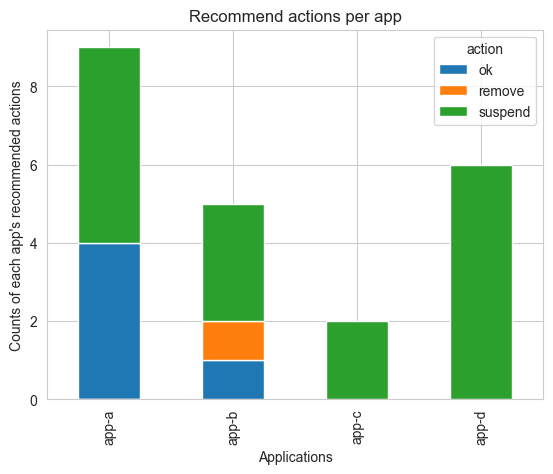

In [31]:
df_action_count.plot(kind='bar', stacked=True)
plt.xlabel('Applications')
plt.ylabel('Counts of each app\'s recommended actions')
 
# title of plot
plt.title("Recommend actions per app")
